In [640]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import math
import numpy as np

random_seed = 1

np.random.seed(random_seed)
from tqdm import tqdm

In [641]:
path = "../training_data/sets/components regression.csv"

data = pd.read_csv(path)

# Correct data types:
# - object -> string
# - int64 -> int32
for col in data.columns:
    if data[col].dtype == "object":
        # convert to string
        data[col] = data[col].astype("string")
    elif data[col].dtype == "int64":
        # convert to int32
        data[col] = data[col].astype("int")

# transform the booleans into 0 and 1
data = data * 1

cols_with_1 = [col for col in data.columns if ' 1' in col and not 'Win' in col]
cols_with_2 = [col for col in data.columns if ' 2' in col]
other_cols = [col for col in data.columns if col not in cols_with_1 + cols_with_2]

sorted_cols = cols_with_1 + cols_with_2 + other_cols
data = data[sorted_cols]

data.head()

,Selection 1 - ProgressiveHistory,Selection 1 - Random,Selection 1 - UCB1,Selection 1 - UCB1GRAVE,Selection 1 - UCB1Tuned,Exploration 1,Play-out 1 - MAST,Play-out 1 - NST,Play-out 1 - Random,Play-out 1 - Random0,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Win rate of Agent 1
0,0,0,1,0,0,0.600000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.00
1,0,1,0,0,0,1.414214,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.80
2,0,1,0,0,0,1.414214,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.10
3,0,0,1,0,0,0.600000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.00
4,0,1,0,0,0,1.414214,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.15


In [642]:
train, test = train_test_split(data, test_size=0.2, random_state=random_seed, shuffle=True)

# get the win rate out of the data
# the oracle value represent the "reward" an optimal user would get for a given context
train_oracle_value = data.iloc[:, -1].to_numpy()
train_oracle_value[train_oracle_value < 0.5] = 1 - train_oracle_value[train_oracle_value < 0.5]

test_oracle_value = test.iloc[:, -1].to_numpy()
test_oracle_value[test_oracle_value < 0.5] = 1 - test_oracle_value[test_oracle_value < 0.5]

# train = train.iloc[:, :-1]
# test = test.iloc[:, :-1]

In [643]:
expansion = ['ProgressiveHistory', 'Random', 'UCB1', 'UCB1GRAVE', 'UCB1Tuned']
exploration = [0.1, 0.6, 1.41421356237]
play_out = ['NST', 'MAST', 'Random', 'Random0', 'Random200', 'Random4']
agent_combinations = 61
agent_context_length = len(expansion) + 1 + len(play_out)
agent_context = np.zeros((agent_combinations, agent_context_length))

index = 0
for e in expansion:
    for exp in exploration:
        for p in play_out:
            if e == 'Random' and (exp != 1.41421356237 or p != 'Random') or p == 'Random' and (
                    e != 'Random' or exp != 1.41421356237):
                continue

            expansion_context_one_hot = np.zeros(len(expansion))
            expansion_context_one_hot[expansion.index(e)] = 1
            exploration_context = exp
            play_out_context_one_hot = np.zeros(len(play_out))
            play_out_context_one_hot[play_out.index(p)] = 1
            agent_context[index] = np.concatenate(
                (expansion_context_one_hot, [exploration_context], play_out_context_one_hot))
            index += 1

In [644]:
def bandit_softmax(wanted: float | np.ndarray, pi: [float | np.ndarray]) -> float:
    """
    This function returns the softmax probability of the wanted action given the current policy pi
    :param wanted: the value of the action for which we want to find the probability
    :param pi: the current policy with the z-values (context dot weights) for each action
    :return: the probability of choosing the wanted action
    """
    pi = np.array(pi).squeeze()
    max_val = np.max(pi, axis=0)
    wanted_rel = (wanted - max_val).astype(float)
    pi_rel = (pi - max_val).astype(float)

    numerator = np.exp(wanted_rel)
    denominator = np.zeros(wanted.shape)
    for p in pi_rel:
        denominator += np.exp(p)
    return numerator / denominator


def generate_batches(data: pd.DataFrame, batch_size: int) -> [pd.DataFrame]:
    """
    This function generates batches of data
    :param data: the data from which we generate the batches
    :param batch_size: the size of the batches
    :return: the batches
    """
    batches = []
    n_splits = math.floor(len(data) / batch_size)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    kf.get_n_splits(data)
    for _, (train_index, test_index) in enumerate(kf.split(data)):
        batches.append(data.iloc[test_index])
    return batches


def shuffle_arrays_in_unison(arr):
    """
    This function shuffles an array
    :param arr: the array to shuffle
    """
    p = np.random.permutation(len(arr[0]))
    ret_arr = []
    for i in range(len(arr)):
        ret_arr.append(arr[i][p])
    return ret_arr


def split_array_into_batches(arr, k):
    n = arr.shape[0]
    num_batches = n // k
    batches = [arr[i * k:(i + 1) * k] for i in range(num_batches)]
    if n % k != 0:
        batches.append(arr[num_batches * k:])
    return batches

In [645]:
batch_size = 10
context_length_61_arms = 184

In [646]:
#Code block for 2 arm MAB
other_cols_wo_winrate = [col for col in other_cols if not 'Win' in col]
data_2_arm_a1 = cols_with_1 + other_cols_wo_winrate
data_2_arm_a1 = train[data_2_arm_a1].to_numpy()

data_2_arm_a2 = cols_with_2 + other_cols_wo_winrate
data_2_arm_a2 = train[data_2_arm_a2].to_numpy()

win_rate_agent1 = train['Win rate of Agent 1'].to_numpy()
win_rate_agent2 = 1 - win_rate_agent1

agent1_general_context = np.concatenate((np.zeros_like(data_2_arm_a2), data_2_arm_a2, train[cols_with_1].to_numpy()),
                                        axis=1).T
agent2_general_context = np.concatenate((data_2_arm_a1, np.zeros_like(data_2_arm_a1), train[cols_with_2].to_numpy()),
                                        axis=1).T

shuffled_arrays = shuffle_arrays_in_unison(
    [agent1_general_context.T, agent2_general_context.T, win_rate_agent1, win_rate_agent2])
agent1_general_context = shuffled_arrays[0]
agent2_general_context = shuffled_arrays[1]
win_rate_agent1 = shuffled_arrays[2].reshape(-1, 1)
win_rate_agent2 = shuffled_arrays[3].reshape(-1, 1)

agent1_batches = split_array_into_batches(agent1_general_context, batch_size)
agent2_batches = split_array_into_batches(agent2_general_context, batch_size)
win_rate_agent1_batches = split_array_into_batches(win_rate_agent1, batch_size)
win_rate_agent2_batches = split_array_into_batches(win_rate_agent2, batch_size)

In [647]:
weights_2_arms = np.random.rand(agent1_general_context.shape[1]).reshape(-1, 1)

In [648]:
alpha = 0.05
n_loops = 10
for e in range(n_loops):
    print('Loop: ' + str(e + 1) + '/' + str(n_loops), end='\r')
    for agent1_batch, agent2_batch, win_rate_agent1_batch, win_rate_agent2_batch in zip(agent1_batches, agent2_batches,
                                                                                        win_rate_agent1_batches,
                                                                                        win_rate_agent2_batches):
        z1 = np.dot(weights_2_arms.T, agent1_batch.T)
        z2 = np.dot(weights_2_arms.T, agent2_batch.T)
        pi1 = bandit_softmax(z1, [z1, z2]).T
        pi2 = bandit_softmax(z2, [z1, z2]).T

        avg = (pi1 * agent1_batch + pi2 * agent2_batch) / 2

        reward = np.empty_like(agent1_batch[:, 0])

        cont = np.empty_like(agent1_batch)

        for i in range(len(reward)):
            if pi1[i] > pi2[i]:
                reward[i] = win_rate_agent1_batch[i]
                cont[i] = agent1_batch[i, :]
            else:
                reward[i] = win_rate_agent2_batch[i]
                cont[i] = agent2_batch[i, :]

        w_update = cont - avg
        w_update = alpha * reward.reshape(-1, 1) * w_update
        w_update = np.mean(w_update, axis=0)

        weights_2_arms = weights_2_arms + w_update.reshape(-1, 1)



In [649]:
other_cols_wo_winrate = [col for col in other_cols if not 'Win' in col]
test_2_arm_a1 = cols_with_1 + other_cols_wo_winrate
test_2_arm_a1 = test[test_2_arm_a1].to_numpy()

test_2_arm_a2 = cols_with_2 + other_cols_wo_winrate
test_2_arm_a2 = test[test_2_arm_a2].to_numpy()

win_rate_agent1_test = test['Win rate of Agent 1'].to_numpy()
win_rate_agent2_test = 1 - win_rate_agent1_test

agent1_test_context = np.concatenate((np.zeros_like(test_2_arm_a2), test_2_arm_a2,
                                      test[cols_with_1].to_numpy()), axis=1).T
agent2_test_context = np.concatenate((test_2_arm_a1, np.zeros_like(test_2_arm_a1),
                                      test[cols_with_2].to_numpy()), axis=1).T

test_z1 = np.dot(weights_2_arms.T, agent1_test_context)
test_z2 = np.dot(weights_2_arms.T, agent2_test_context)
test_p1 = bandit_softmax(test_z1, [test_z1, test_z2])
test_p2 = bandit_softmax(test_z2, [test_z1, test_z2])

regret = test_oracle_value - (test_p1 * win_rate_agent1_test + test_p2 * win_rate_agent2_test)
print(regret.mean())

0.0


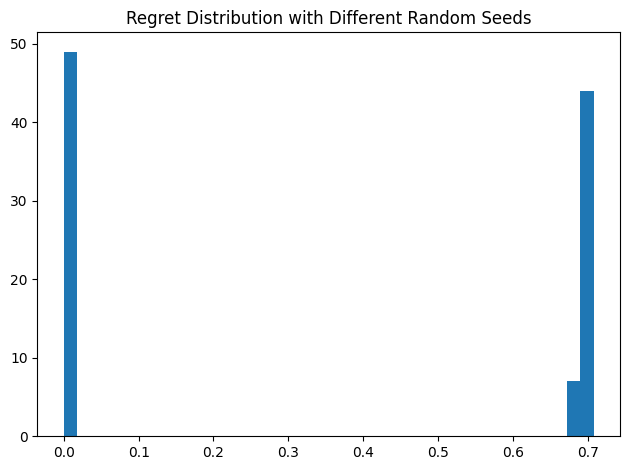

average regret: 0.35493408948706695


In [650]:
import matplotlib.pyplot as plt

random_seed_regret_results = pd.read_csv('mab_2_arms_regret_results.csv').to_numpy()
plt.hist(random_seed_regret_results, bins=40)
plt.title("Regret Distribution with Different Random Seeds")
plt.tight_layout()
plt.show()
print('average regret: ' + str(random_seed_regret_results.mean()))

In [651]:
train_61_arms_environment_context = train[cols_with_2 + other_cols_wo_winrate]
context_per_agent = []

for agent in agent_context:
    agent = np.tile(agent, (len(train_61_arms_environment_context), 1))

    context_per_agent.append(np.concatenate((train_61_arms_environment_context, agent), axis=1))

agent1_61_arms = train[cols_with_2 + other_cols_wo_winrate + cols_with_1].to_numpy()
shuffled_arrays_61_arms = shuffle_arrays_in_unison([agent1_61_arms, win_rate_agent1] + context_per_agent)

agent1_61_arms = shuffled_arrays_61_arms[0]
win_rate_agent1_61_agents = shuffled_arrays_61_arms[1].reshape(-1, 1)
context_per_agent = shuffled_arrays_61_arms[2:]

agent1_61_arms_batches = split_array_into_batches(agent1_61_arms, batch_size)
win_rate_agent1_61_agents_batches = split_array_into_batches(win_rate_agent1_61_agents, batch_size)
context_per_agent_batches = []
for context in context_per_agent:
    context_per_agent_batches.append(split_array_into_batches(context, batch_size))

In [652]:
weights_61_arms = np.random.rand(context_length_61_arms).reshape(-1, 1)

In [653]:
alpha = 0.05
n_loops = 1

for e in range(n_loops):
    print('Loop: ' + str(e + 1) + '/' + str(n_loops), end='\r')
    for agent1_batch, win_rate_agent1_61_agents_batch, i in zip(agent1_61_arms_batches,
                                                                win_rate_agent1_61_agents_batches,
                                                                range(len(agent1_61_arms_batches))):
        z1 = np.dot(weights_61_arms.T, agent1_batch.T)
        z_agent = []
        for context_batch in context_per_agent_batches:
            z_agent.append(np.dot(weights_61_arms.T, context_batch[i].T))

        pi1 = bandit_softmax(z1, z_agent).T
        pi_agent = []
        for z in z_agent:
            pi_agent.append(bandit_softmax(z, z_agent).T)

        avg = np.zeros_like(agent1_batch)
        for j in range(len(pi_agent)):
            avg += pi_agent[j] * context_per_agent_batches[j][i]

        avg = avg / len(pi_agent)

        cont = agent1_batch
        reward = win_rate_agent1_61_agents_batch
        w_update = cont - avg
        w_update = alpha * reward * w_update
        w_update = np.mean(w_update, axis=0)

        weights_61_arms = weights_61_arms + w_update.reshape(-1, 1)

In [654]:
test_61_arms_environment_context = test[cols_with_2 + other_cols_wo_winrate]
context_per_agent = []

for agent in agent_context:
    agent = np.tile(agent, (len(test_61_arms_environment_context), 1))

    context_per_agent.append(np.concatenate((test_61_arms_environment_context, agent), axis=1))

agent1_61_arms_test = test[cols_with_2 + other_cols_wo_winrate + cols_with_1].to_numpy()
agent2_61_arms_test = test[cols_with_2 + other_cols_wo_winrate + cols_with_2].to_numpy()

win_rate_agent1_test = test['Win rate of Agent 1'].to_numpy()
win_rate_agent2_test = 1 - win_rate_agent1_test
test_z1 = np.dot(weights_61_arms.T, agent1_61_arms_test.T)
test_z2 = np.dot(weights_61_arms.T, agent2_61_arms_test.T)
test_z_agent = []
for context in context_per_agent:
    test_z_agent.append(np.dot(weights_61_arms.T, context.T))

test_p1 = bandit_softmax(test_z1, test_z_agent)
test_p2 = bandit_softmax(test_z2, test_z_agent)

regret = test_oracle_value - (test_p1 * win_rate_agent1_test + test_p2 * win_rate_agent2_test)
print(regret.mean())

0.6190407275406947


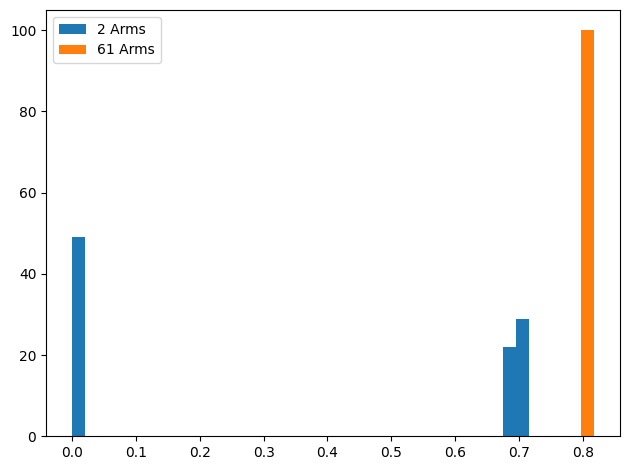

average regret: 0.35493408948706695
average regret: 0.8096874124838738


In [656]:
random_seed_regret_results_2_arms = pd.read_csv('mab_2_arms_regret_results.csv').to_numpy()
random_seed_regret_results_61_arms = pd.read_csv('mab_61_arms_regret_results.csv').to_numpy()
bins = np.histogram(np.hstack((random_seed_regret_results_2_arms, random_seed_regret_results_61_arms)), bins=40)[1]
plt.hist(random_seed_regret_results_2_arms, bins=bins)
plt.hist(random_seed_regret_results_61_arms, bins=bins)
# plt.title("Regret Distribution with Different Random Seeds")
plt.legend(['2 Arms', '61 Arms'])
plt.tight_layout()
plt.show()
print('average regret: ' + str(random_seed_regret_results_2_arms.mean()))
print('average regret: ' + str(random_seed_regret_results_61_arms.mean()))